<br><br><p style="text-align:center;font-size:2em;font-weight: bold;text-decoration: underline">Rider Classification</p>
<br>
<h1>Abstract</h1>
<p> The goal of this project is to classify whether a rider is a <span style="font-weight:900">Registered</span> or <span style="font-weight:900">Casual</span> bicyclist from data collected about the rider's rental of a bicycle. The data comes from <span style="font-style:italic"><a href="https://www.capitalbikeshare.com">Capital Bike Share</a></span>, a bike sharing company located in Washington D.C.</p>

<p> For each bike rental a start time and rental duration is recorded along with the start and end locations of the rental. In the Storing Distance Data notebook python code is run to determine how long Google says it takes to go from  one location to another. The address data was created from mining the data sets. There are some duplicates (because some address strings were entered in different ways) and two addresses do not appear ("Birthday Station", and "Alta Bicycle Share Demonstration Station") as they do not have latitude and longitude coordinates. In the code for these two locations we chose the time to destination as 0. </p>

<p> The other notebook is the Data Clean notebook which takes the raw data from the System Data location below and converts it into a more useable form. It also queries the distance array (whose rows and columns are indexed corresponding to their row in the address data set) to determine how long it takes to bicycle from the start to the end location. The end result is each entry in the original data set corresponds to a start and end location, whether it was a holiday, whether it was a business day, the start time of the ride, whether the ride began at the same location, the duration the bicycle was taken, how far between stations it took to ride, and finally what type of rider the entry corresponds to. Also, incomplete data is removed from the data sets.</p>

<p> In this notebook we take the cleaned data and see how well our features we mined help predict the type of rider.
In particular, the code below takes the second quarter data of 2016 to help predict the classification of the entries from the first quarter in 2017 data set. The code below takes 10,000 random entries from the training set along with 10,000 random entries for a validation set and predicts a random test set of size 10,000 to approximate how well the various classifiers perform.</p>

<p> This notebook uses the entire training data to add two more feature columns to the data set. Namely, it looks at how often stations are used to start and end and includes these entries into each entry before passing the data set to the classifiers. We include four different classifiers (Logistic, Decision Tree, Adaboost, and Gradient Boost) in the code below and show that they perform fairly similarly to each other. Additionally we provide a visualization of the Decision Tree classifier which gives insight into how different features interplay to help predict the type of rider. In the final part of the notebook further potential directions are discussed in how to potentially improve on the model's accuracy.</p>

Website with Initial Data Sets: <a href="https://www.capitalbikeshare.com/system-data">System Data</a>
Zipped Data Clean File available here: <a href="http://math.colgate.edu/~dmhoward/DataClean.zip">Data Clean</a>

# Loading in the Libraries and Data

In [1]:
# Libraries that we know and love.
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree as Tree
from sklearn.ensemble import AdaBoostClassifier

In [2]:
def findIndex(station):
    try:
        
        # These two locations have no address so we return 0 and later we will change the Time to Destination to 0
        if(station=='Alta Bicycle Share Demonstration Station' or station=='Birthday Station'):
            return -1
        else:
            return addressdata.index[addressdata['Address']==station][0]
    except:
        # If there is a station that doesn't match output print it
        print(station)

In [3]:
# Read 162 Training file
frame = pd.read_csv('DataClean/Train/DataCleaned162.csv')

In [4]:
# Read 171 Test File
frame2= pd.read_csv('DataClean/Test/DataCleaned171.csv')

In [5]:
# Chose two seeds for the randomization the first for the training data the second for the test data
np.random.seed(125)
perm = np.random.permutation(len(frame))
np.random.seed(120)
perm2=np.random.permutation(len(frame2))
trainSize = 10000 # Training Size is initialized
validSize = 10000 # Validation Size is initialized
testSize = 10000 # Test Size is initialized

In [6]:
# Choose Training size number of points for Validation and Training Size
trainingdata=frame.iloc[perm[:trainSize],:]
validationdata=frame.iloc[perm[trainSize:trainSize+validSize],:]

In [7]:
# Take testSize number of points from the test data set to check accuracy
testdata=frame2.iloc[perm2[:testSize],:]

In [8]:
# Create Training Numpy Arrays for analysis
Xtrain=np.array(trainingdata.iloc[:,3:-1])
ytrain=np.array(trainingdata.iloc[:,-1])

In [9]:
# Create Validation Numpy Arrays for analysis
Xvalid=np.array(validationdata.iloc[:,3:-1])
yvalid=np.array(validationdata.iloc[:,-1])

In [10]:
# Create Test Numpy Arrays for analysis
Xtest=np.array(testdata.iloc[:,3:-1])
ytest=np.array(testdata.iloc[:,-1])

In [11]:
# Load the Address data
addressdata=pd.read_csv('Myaddrdata.csv')

In [12]:
# Full training data frame to analyze probabilities
Memberdf=frame.loc[frame['Member Type']==1]
Casualdf=frame.loc[frame['Member Type']==0]

In [13]:
# Probability that a bike is taken by a member, the "base probability"
probmember=len(Memberdf)/len(frame)
print("The base likelihood a rider is registered: ", probmember)

The base likelihood a rider is registered:  0.7779455648327765


In [14]:
# Create Numpy Arrays with the probmember as the default probability
probMemStart=np.full_like(np.array(np.arange(len(addressdata))),probmember,dtype=float)
probMemEnd=np.full_like(np.array(np.arange(len(addressdata))),probmember,dtype=float)

# In the Entire Training Set find the number of times a particular location was taken 
# as a start and as an end station by both a casual member and a registered member.
Membercounts1=Memberdf['Start station'].value_counts()
Membercounts2=Memberdf['End station'].value_counts()
Casualcounts1=Casualdf['Start station'].value_counts()
Casualcounts2=Casualdf['End station'].value_counts()

In [15]:
# This updates the probability that a particular station is used by a registered member
# In the Member and Casual Count arrays lookup how many times a particular address location is 
# used as a start and end location. Some addresses are not used so a Key Error is raised when
# trying to access it in the casual and member count arrays
for i in range(len(addressdata)):
    
    #### Start Station Lookups ####
    try:
        CasInd=Casualcounts1.index.get_loc(addressdata['Address'][i])
    except KeyError: 
        CasInd=-1 # Index not found, No Casual Riders started from this station
    try:
        MemInd=Membercounts1.index.get_loc(addressdata['Address'][i])
    except KeyError:
        MemInd=-1 # Index not found, No Registered Members started from this station
        
    # For a particular location decide whether to use a probability of 
    # 0 (if no Registered Member started at the station, but Casual Riders did)
    # 1 (if no Casual started at the station, but Registered Riders did)
    # Base probability (if no one used the station)
    # Registered Members/Total Riders (most frequent case)
    if(MemInd==-1 and CasInd>-1):
        probMemStart[i]=0
    elif(CasInd==-1 and MemInd>-1):
        probMemStart[i]=1
    elif(MemInd==-1 and CasInd==-1):
        pass
    else:
        probMemStart[i]=Membercounts1[MemInd]/(Casualcounts1[CasInd]+Membercounts1[MemInd])
        
    #### End Station Lookups ####
    try:
        CasInd=Casualcounts2.index.get_loc(addressdata['Address'][i])
    except KeyError:
        CasInd=-1 # Index not found, No Casual Riders started from this station
    try:
        MemInd=Membercounts2.index.get_loc(addressdata['Address'][i])
    except KeyError:
        MemInd=-1 # Index not found, No Registered Members started from this station

    # For a particular location decide whether to use a probability of 
    # 0 (if no Registered Member started at the station, but Casual Riders did)
    # 1 (if no Casual started at the station, but Registered Riders did)
    # Base probability (if no one used the station)
    # Registered Members/Total Riders (most frequent case)
    if(MemInd==-1 and CasInd>-1):
        probMemEnd[i]=0
    elif(CasInd==-1 and MemInd>-1):
        probMemEnd[i]=1
    elif(MemInd==-1 and CasInd==-1):
        pass
    else:
        probMemEnd[i]=Membercounts2[MemInd]/(Casualcounts2[CasInd]+Membercounts2[MemInd])

In [16]:
#### Find the probabilities for the Start Station Training Data ####
probarray=np.full_like(np.array(np.arange(len(Xtrain))),probmember,dtype=float) # Initialize probability array
for i in range(len(Xtrain)):
    myindex=findIndex(trainingdata.iloc[i]['Start station'])
    if(myindex==-1):
        pass
    else:
        # Stores the probability a start station is used by a Registered Member
        probarray[i]=probMemStart[myindex] 
        
# Add the column to the Training Numpy Array
Xtrain=np.column_stack((Xtrain,probarray))

#### Find the probabilities for the End Station Training Data ####
probarray=np.full_like(np.array(np.arange(len(Xtrain))),probmember,dtype=float) # Re-initialize probability array
for i in range(len(Xtrain)):
    myindex=findIndex(trainingdata.iloc[i]['End station'])
    if(myindex==-1):
        pass
    else:
        # Stores the probability an end station is used by a Registered Member
        probarray[i]=probMemEnd[myindex]
        
# Add the column to the Training Numpy Array
Xtrain=np.column_stack((Xtrain,probarray))

In [17]:
#### Find the probabilities for the Start Station Validation Data ####
probarray=np.full_like(np.array(np.arange(len(Xvalid))),probmember,dtype=float) # Initialize probability array
for i in range(len(Xvalid)):
    myindex=findIndex(validationdata.iloc[i]['Start station'])
    if(myindex==-1):
        pass
    else:
        # Stores the probability a start station is used by a Registered Member
        probarray[i]=probMemStart[myindex] 
        
# Add the column to the Validation Numpy Array
Xvalid=np.column_stack((Xvalid,probarray))

#### Find the probabilities for the End Station Validation Data ####
probarray=np.full_like(np.array(np.arange(len(Xvalid))),probmember,dtype=float) # Re-initialize probability array
for i in range(len(Xvalid)):
    myindex=findIndex(validationdata.iloc[i]['End station'])
    if(myindex==-1):
        pass
    else:
        # Stores the probability an end station is used by a Registered Member
        probarray[i]=probMemEnd[myindex]
        
# Add the column to the Validation Numpy Array
Xvalid=np.column_stack((Xvalid,probarray))

In [18]:
#### Find the probabilities for the Start Station Test Data ####
probarray=np.full_like(np.array(np.arange(len(Xtest))),probmember,dtype=float) # Initialize probability array
for i in range(len(Xtest)):
    myindex=findIndex(testdata.iloc[i]['Start station'])
    if(myindex==-1):
        pass
    else:
        # Stores the probability a start station is used by a Registered Member
        probarray[i]=probMemStart[myindex] 
        
# Add the column to the Testing Numpy Array
Xtest=np.column_stack((Xtest,probarray))

#### Find the probabilities for the End Station Test Data ####
probarray=np.full_like(np.array(np.arange(len(Xtest))),probmember,dtype=float) # Re-initialize probability array
for i in range(len(Xtest)):
    myindex=findIndex(testdata.iloc[i]['End station'])
    if(myindex==-1):
        pass
    else:
        # Stores the probability an end station is used by a Registered Member
        probarray[i]=probMemEnd[myindex]
        
# Add the column to the Testing Numpy Array
Xtest=np.column_stack((Xtest,probarray))

# Prediction Models

<p> In what follows we run a number of prediction classifiers. We notice a 
consistent theme from the classifiers that the training set,
validation set, and test set all perform between 89% plus or minus 2%.</p>

<p> At first it may seem odd that the Test score is consistently above the
Training/Validation Scores. The reason for this event is likely a direct result that there
is about a 1% higher amount of registered users in the test set than in the 
validation and training sets. As the registered users amount to around
three quarters of the set the increase in the number of registered users would likely only
increase the accuracy of the prediction model.</p>

In [19]:
# Logistic Regression Model
LR=LogisticRegression().fit(Xtrain,ytrain)

print("Training Score: ", LR.score(Xtrain,ytrain))
print("Validation Score: ", LR.score(Xvalid,yvalid))
print("Test Score: ", LR.score(Xtest,ytest))

Training Score:  0.8755
Validation Score:  0.8751
Test Score:  0.891


In [20]:
# Decision Tree Model
DTC=DecisionTreeClassifier(max_depth=5).fit(Xtrain,ytrain)

print("Training Score: ", DTC.score(Xtrain,ytrain))
print("Validation Score: ", DTC.score(Xvalid,yvalid))
print("Test Score: ", DTC.score(Xtest,ytest))

Training Score:  0.8901
Validation Score:  0.8791
Test Score:  0.8979


In [21]:
# Adaboost Classifier (Only slightly better than just a straight Decision Tree incidentally)
ADA=AdaBoostClassifier(learning_rate=.4).fit(Xtrain,ytrain)

print("Training Score: ", ADA.score(Xtrain,ytrain))
print("Validation Score: ", ADA.score(Xvalid,yvalid))
print("Test Score: ", ADA.score(Xtest,ytest))

Training Score:  0.8947
Validation Score:  0.8946
Test Score:  0.9067


In [22]:
# Stochastic Gradient Boost Classifier (Best Performer)
GBC=GradientBoostingClassifier(n_estimators=50, random_state=0, learning_rate=.1).fit(Xtrain,ytrain)

print("Training Score: ", GBC.score(Xtrain,ytrain))
print("Validation Score: ", GBC.score(Xvalid,yvalid))
print("Test Score: ", GBC.score(Xtest,ytest))

Training Score:  0.9028
Validation Score:  0.8937
Test Score:  0.9101


# Decision Tree Visualization

<p> Looking at the Decision Tree Classifier we can visualize how Registered and Casual Riders
differed. There a number of properties that you can take from this visualization. The most influential feature seems to be the length of ride. The longer the ride the more likely the rider
was a casual rider. In particular, about 25 minutes or longer favored the Casual Riders more than
2:1 where as registered users appear in a ratio of 7:1 when the ride duration was less than 25 minutes.
Furthermore, by looking at the tree we can see a correlation between the duration and the time to 
a rider's destination. Other factors affected the prediction such as the choice of stations
(certain stations are preferred by Casual Riders and correspond to Registered Start/End Prob being
lower), whether the day was a business day, or the hour the trip began. Interestingly, at no point did the holiday feature become important; possibly because a non-business day behaves the same as a holiday. Additionally, the same location feature does need not be used because this feature is encompassed when the Time to 
Destination is 0.</p>

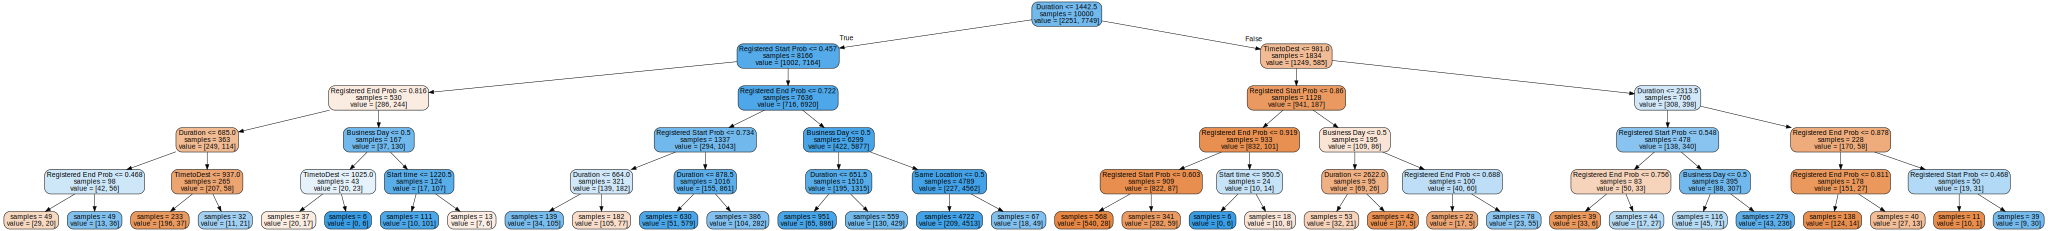

In [23]:
import graphviz

# Create the feature list names 
featurelist=list(frame.columns[3:9])
featurelist.append("Registered Start Prob")
featurelist.append("Registered End Prob")

# A visualization of the Decision Tree Classifier
f = Tree.export_graphviz(DTC, out_file=None,feature_names=featurelist,filled=True, 
                         rounded=True, special_characters=False,impurity=False)
f=f[0:15]+'size="40!";\n' +f[15:] # Edit the string file directly to alter the image size
graph = graphviz.Source(f)  

# Display the graph
graph

<h1>Further Directions Discussion</h1>

<p>A straight guess that every rider is a registered rider yields an accuracy result of 77-78%,
therefore mining for these other features sees an improvement in accurarcy. In order to potentially increase the
accuracy of the model it may be useful to start fine tuning more of the probabilities.
For example, the Registered Start/End Prob features (the probability a cyclist is casual or
registered and knowing where they took or left a bicycle) are a complete average over the entire
sample. It may by useful if we refine these probabilities in terms of
time of day and business vs. non-business days. Additionally, running the duration
between stops at different times of the day (to compensate for heavier traffic) may yield
some increase in predictability. Lastly, this notebook uses fairly recent data. It
may be interesting to see the interplay between other quarters other than the ones used here. In
earlier data sets for example the number of casual riders (percentage-wise) is much higher.</p>